In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
#%matplotlib inline
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, plot_yearly, plot_forecast_component
from time import strptime, strftime
from funcs import *
from bokeh.plotting import figure, output_file, show


1. [Spend Data](#SpendData)
2. [Revenue and Calls Data](#Revenue_and_Calls)  
2.1 [Calls-to-Rev Ratio](#callstorev)  
2.2 [Rev-to-Calls Ratio](#revtocalls)
3. [explorerevenue.ipynb stuff](#explorerevenue_copied)

 <a name="SpendData"></a>
# Spend Data

This section wrangles the spend data from 2014-2017 into a single dataframe

**spend** (dataframe):  
index     - date (first of each month); pd.datetime format  
columns- brands

**brands** (list of strings)

**branddict** (dictionary with brand abbrev's as keys)

In [3]:
raw14 = pd.read_excel('SpendMonthly2014.xlsx', skiprows=range(3), index_col=0)
raw15 = pd.read_excel('SpendMonthly2015.xlsx', skiprows=range(4), index_col=0)
raw16 = pd.read_excel('SpendMonthly2016.xlsx')
raw17 = pd.read_excel('SpendMonthly2017.xlsx')

In [4]:
raw15 = raw15.dropna(how='all')
raw14 = raw14.dropna(how='all')

Each column is repeated 12 times: here's a function that gives list of columns corresp. to months Jan-Dec:

In [5]:
monthlist = lambda x: [x] + [ x + '.' + str(k) for k in range(1,12)]    

In [6]:
# Note: offset alias 'MS' gives beginning of every month.
#       We may want to eg. spread the spend over the month..?

months = lambda year: pd.date_range(start=year+"-01-01", freq="MS", periods=12)
brands = raw15.index.unique().tolist()[1:]

In [7]:
dat = raw15[monthlist('Actuals')].groupby(raw15.index)
spend15 = dat.sum().T
spend15.rename(index={monthlist('Actuals')[i]: months('2015')[i] for i in range(12)}, inplace=True)

dat = raw14[monthlist('Actuals')].groupby(raw14.index)
spend14 = dat.sum().T
spend14.rename(index={monthlist('Actuals')[i]: months('2014')[i] for i in range(12)}, inplace=True)

In [8]:
spend16 = raw16.T.rename(index={raw16.T.index[i]: months('2016')[i] for i in range(12)})
spend17 = raw17.T.rename(index={raw17.T.index[i]: months('2017')[i] for i in range(12)})

In [9]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# from some_utils import *
# mydisplay((spend14.head(n=3), spend15.head(n=3),
#           spend16.head(n=3), spend17.head(n=3)), names=[str(y) for y in range(2014, 2018)])

display_side_by_side(spend14.head(n=3), spend15.head(n=3))
display_side_by_side(spend16.head(n=3), spend17.head(n=3))

FONO 
 GS App 
 GSV 
 IML 
 LLK 
 RDL 
 VBL 
 
 
 
 
 2014-01-01 
 85221.89 
 0.0 
 60770.07 
 9461.04 
 538058.95 
 61220.23 
 22363.66 
 
 
 2014-02-01 
 84837.17 
 0.0 
 56698.15 
 7649.88 
 527281.21 
 48238.97 
 19102.80 
 
 
 2014-03-01 
 92628.65 
 0.0 
 59685.11 
 7586.24 
 585280.97 
 50694.91 
 19105.14 
 
 
 
 
 
 
 FONO 
 GSV 
 IML 
 LBL 
 LLK 
 MM 
 RDL 
 TGO 
 VBL 
 
 
 
 
 2015-01-01 
 105601.61 
 43601.81 
 10399.88 
 587.94 
 634403.14 
 106403.62 
 45372.56 
 185.62 
 18104.50 
 
 
 2015-02-01 
 88844.24 
 39882.00 
 16264.85 
 506.70 
 607560.66 
 93871.09 
 43840.17 
 608.14 
 15479.43 
 
 
 2015-03-01 
 119813.34 
 55658.49 
 25923.88 
 511.01 
 686881.79 
 94677.18 
 40820.44 
 607.91 
 15774.03

,LLK,FONO,CDL,VBL,IML,GSV
2016-01-01,643000,112000,39000,18000,12000,72050
2016-02-01,583000,100000,39000,18000,12000,73550
2016-03-01,608000,100000,39000,18000,12000,74550
,LLK,FONO,CDL,VBL,IML,GSV
2017-01-01,589842.0,111323.0,34796.0,44503.0,35442.058853,28553.310
2017-02-01,598601.0,101884.0,33821.0,34704.0,32027.133607,25301.475
2017-03-01,682777.0,83802.0,37891.0,37466.0,33176.533947,25022.445


Concatenate all spend data; drop empty 'GS App' column:

In [10]:
spend = pd.concat([spend14, spend15, spend16, spend17], sort=True).drop(columns=['GS App'])

In [11]:
spend.columns

Index(['CDL', 'FONO', 'GSV', 'IML', 'LBL', 'LLK', 'MM', 'RDL', 'TGO', 'VBL'], dtype='object')

In [12]:
spend.head()

,CDL,FONO,GSV,IML,LBL,LLK,MM,RDL,TGO,VBL
2014-01-01,NaN,85221.89,60770.07,9461.04,NaN,538058.95,NaN,61220.23,NaN,22363.66
2014-02-01,NaN,84837.17,56698.15,7649.88,NaN,527281.21,NaN,48238.97,NaN,19102.80
2014-03-01,NaN,92628.65,59685.11,7586.24,NaN,585280.97,NaN,50694.91,NaN,19105.14
2014-04-01,NaN,97696.45,72001.22,8352.52,NaN,552035.98,NaN,51329.79,NaN,20338.63
2014-05-01,NaN,91160.62,75381.85,9373.06,NaN,552807.85,NaN,50396.27,NaN,21989.78


In [13]:
# Brand Names:
branddict={'LLK': 'LiveLinks', 'FONO': 'Fonochat', 'RDL': 'Redhot', 'VBL': 'Vibeline', 'IML': 'InteractiveMale', 
 'TGO': 'TangoPersonals', 'LBL': 'LavenderLine', 'GSV': 'GuySpy Voice', 'MM': 'MegaMates'}

In [14]:
brands

['FONO', 'RDL', 'VBL', 'IML', 'TGO', 'LBL', 'GSV', 'MM']

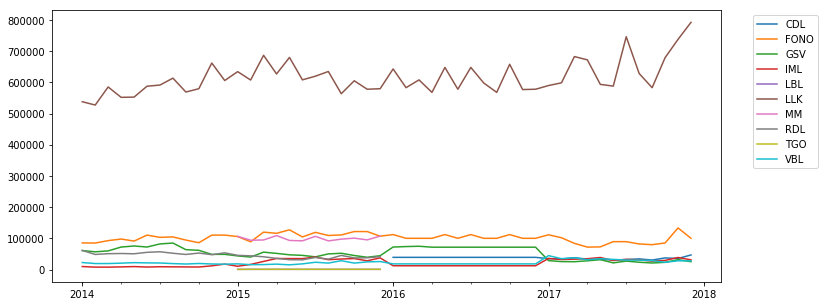

In [15]:
spend.plot(legend=False, figsize=(12,5))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

 <a name="Revenue_and_Calls"></a>
# Revenue and Calls Data

Daily call count and revenue in the following dataframes (index=date):  
- revdaily  
- callsdaily

They both contain the following brands: 
- brands2 = \[ Casual DateLine, Fonochat, GuySpy Voice, InteractiveMale, LiveLinks, TangoPersonals, Vibeline \]

In [16]:
revdaily = pd.read_excel('RevenueDailyAllBrands010110-120918.xls', skiprows=[0,2], index_col=0)
brands2  = revdaily.columns 
revdaily.head(n=3)

,Casual DateLine,Fonochat,GuySpy Voice,InteractiveMale,LiveLinks,TangoPersonals,Vibeline
2010-01-01,15301.998379,10722.7896,NaN,37223.633244,69828.849695,9437.170489,11018.240056
2010-01-02,14130.268201,10922.9006,NaN,35465.973485,71836.647957,9647.400147,8650.354948
2010-01-03,13011.070337,9049.0054,NaN,27983.239376,59105.720264,8854.730920,7687.534200


Index is already datetime format. Great.

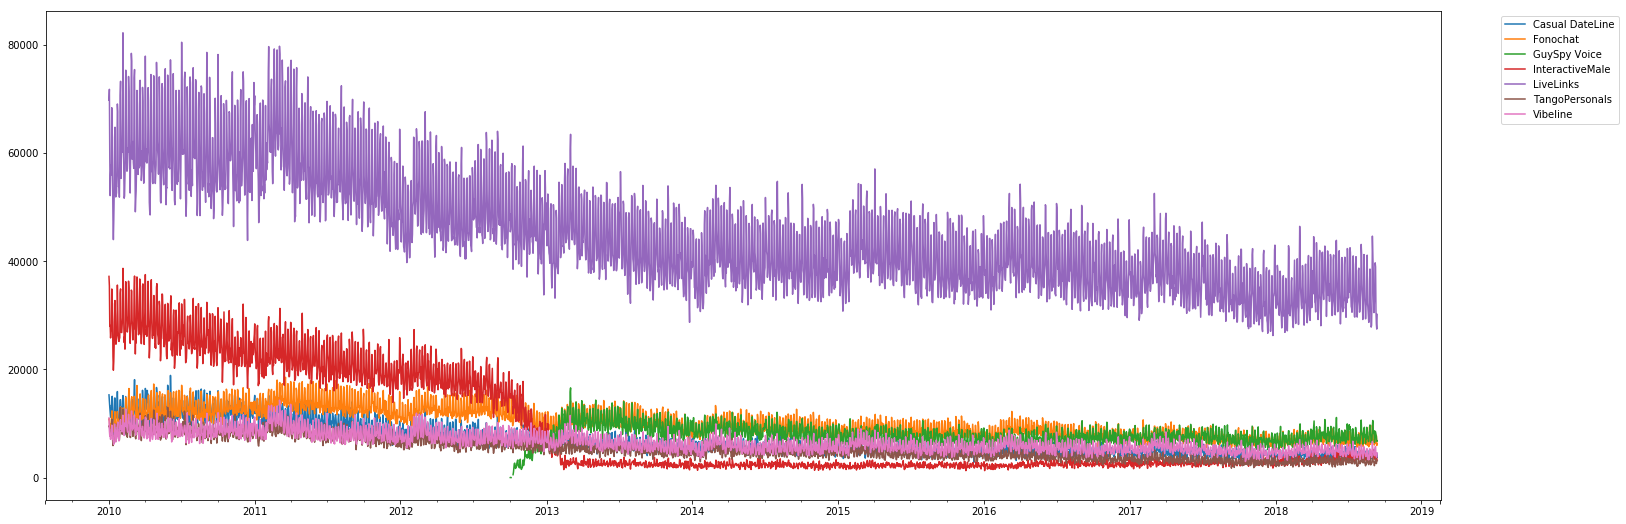

In [17]:
revdaily.plot(legend=False, figsize=(25,9))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

(-1000, 60000)

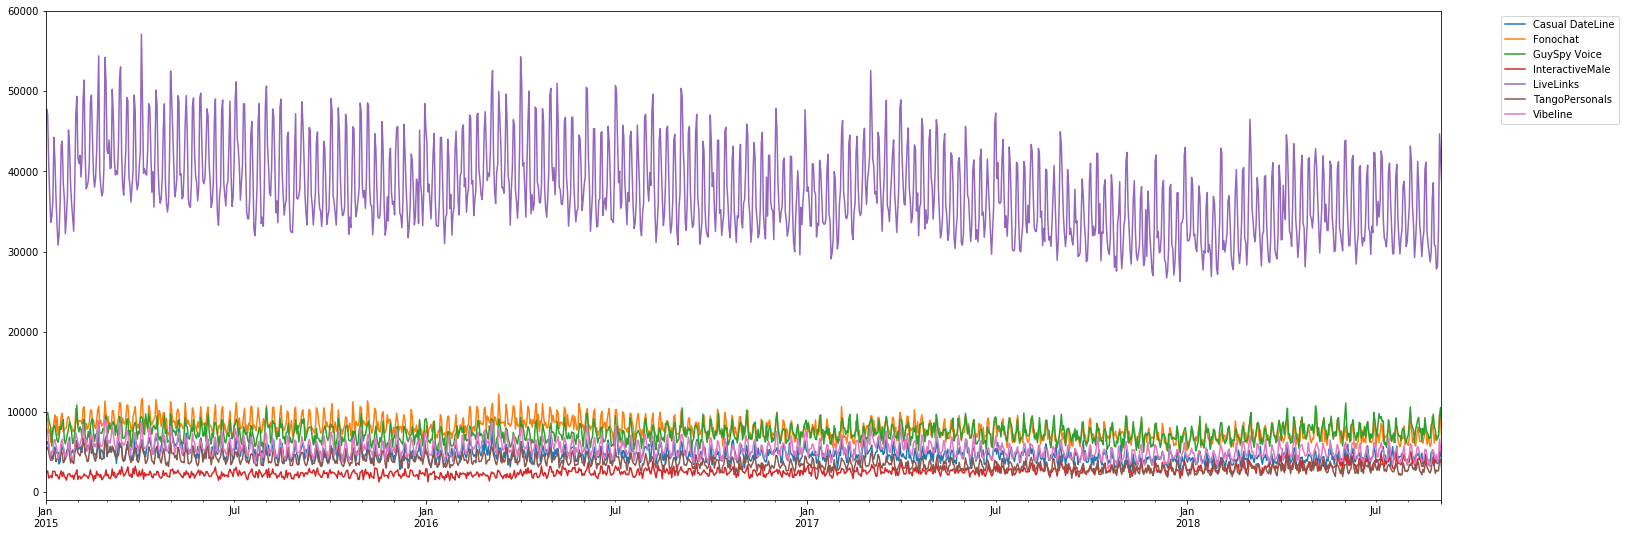

In [18]:
revdaily.plot(legend=False, figsize=(25,9))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.gca().set_xlim(pd.Timestamp('2015-01'), pd.Timestamp('2018-09'))
plt.gca().set_ylim(-1000, 60000)

In [19]:
callsdaily = pd.read_excel('CallsDailyAllBrands010110-120918.xls', skiprows=[0,2], index_col=0)
callsdaily.head(n=3)

,Casual DateLine,Fonochat,GuySpy Voice,InteractiveMale,LiveLinks,TangoPersonals,Vibeline
2010-01-01,41273.0,66223.0,NaN,77898.0,173154.0,43189.0,65178.0
2010-01-02,42850.0,70981.0,NaN,78745.0,187857.0,44969.0,69988.0
2010-01-03,40941.0,66484.0,NaN,71970.0,170024.0,42873.0,67630.0


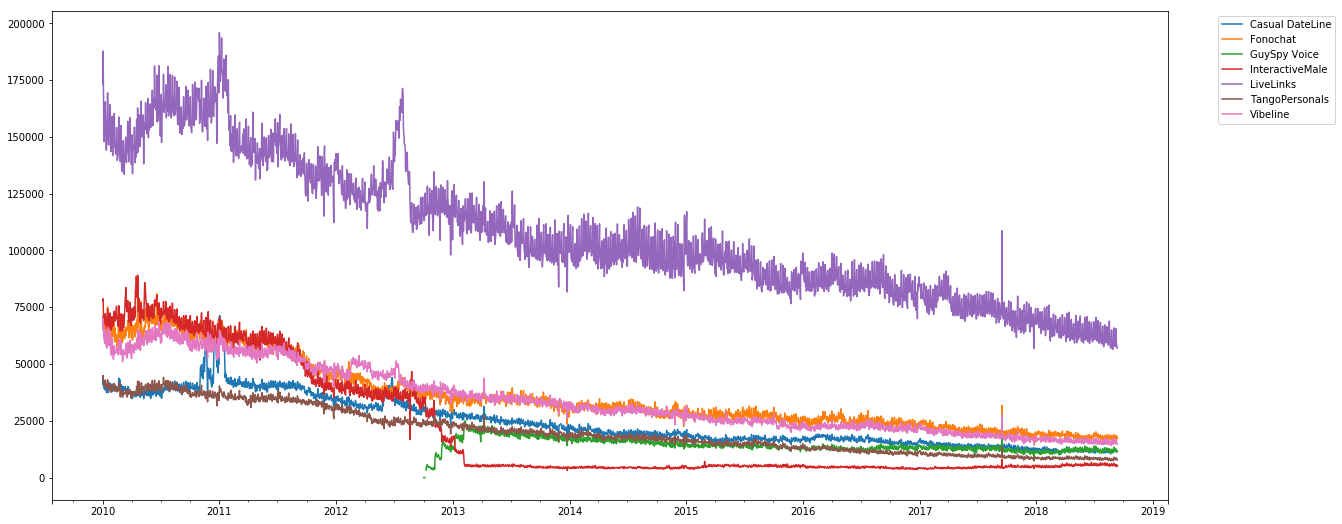

In [20]:
callsdaily.plot(legend=False, figsize=(20,9))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

<a name=callstorev></a>
## Calls-to-Rev ratio

Plot ratio of calls to revenue (i.e. #calls per dollar) over time, for all available brands:

In [21]:
# Note on rolling() method:
# By default, the result is set to the right edge of the window. 
# This can be changed to the center of the window by setting center=True.

# To get average over 'future' calls, need an offset

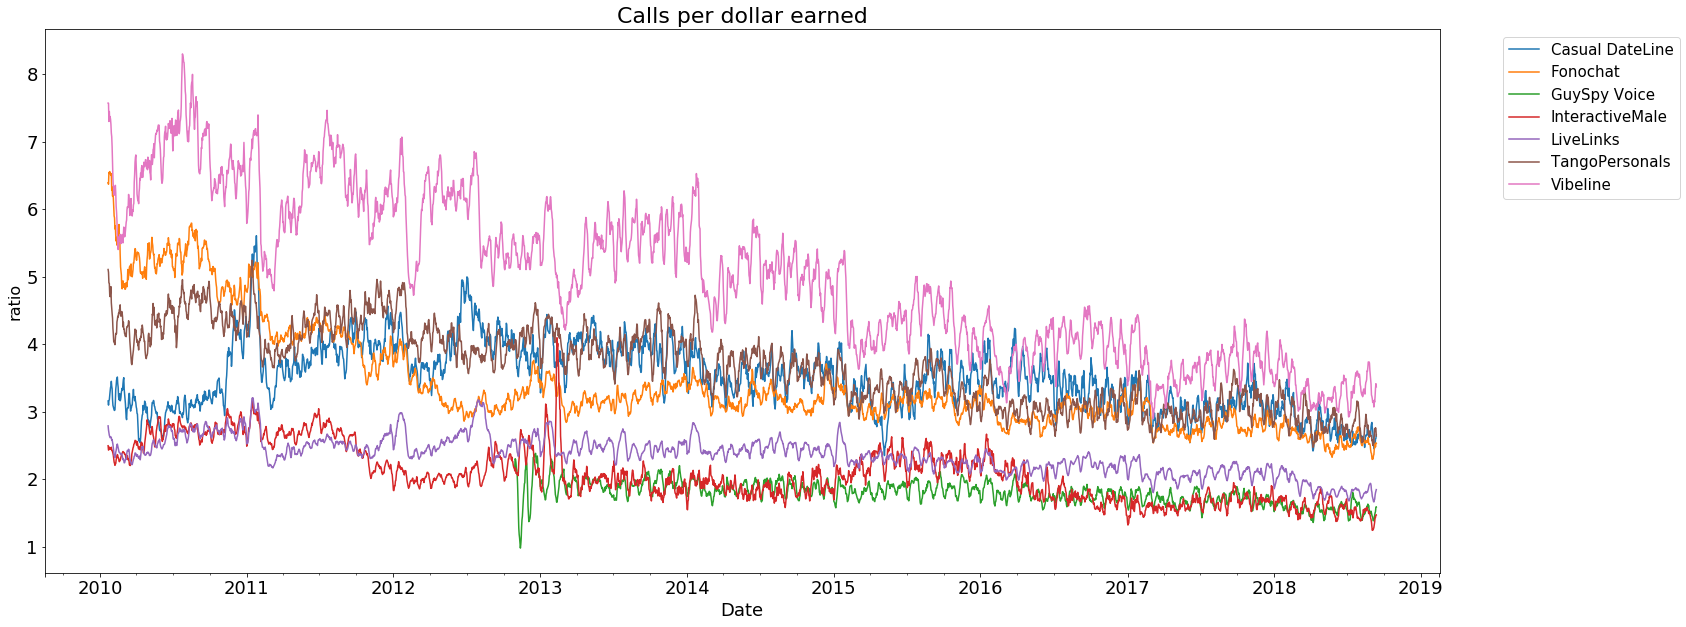

In [42]:
callWin, revWin = [14, 7]    # no. of days to average over

offset = pd.Timedelta(str(callWin-revWin)+' days')

ratio_callsoverrev = pd.DataFrame()

# The following updates parameters globally:  
# params = {'legend.fontsize': 15, 'axes.titlesize': 22, 'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize':16}
# plt.rcParams.update(params)

for brand in brands2:
    ratio_callsoverrev[brand] = callsdaily[brand].rolling(callWin).mean().shift(1, freq=offset).divide(
        revdaily[brand].rolling(revWin).mean())
    ratio_callsoverrev[brand].plot(legend=False, figsize=(25,10))#, title='Calls per dollar earned')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=15), plt.ylabel('ratio')  
plt.gca().set_title('Calls per dollar earned', fontsize=22)
plt.xlabel('Date', fontsize=18); plt.ylabel('ratio', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=18)

Compare size of moving average window (for both rev/calls):

In [30]:
brands2

Index(['Casual DateLine', 'Fonochat', 'GuySpy Voice', 'InteractiveMale',
       'LiveLinks', 'TangoPersonals', 'Vibeline'],
      dtype='object')

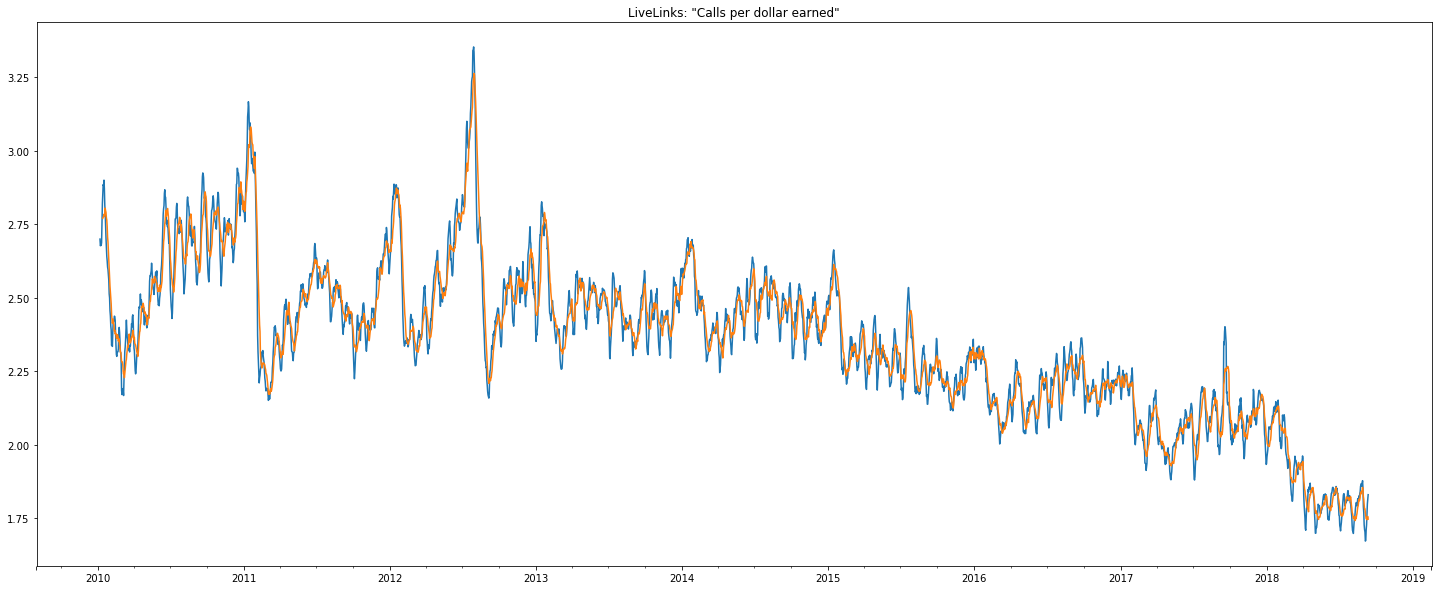

In [33]:
c1, r1, c2, r2 = [7, 7, 14, 14]
br = 'LiveLinks'

ratio1 = callsdaily[br].rolling(c1).mean().divide(revdaily[br].rolling(r1).mean())
ratio2 = callsdaily[br].rolling(c2).mean().divide(revdaily[br].rolling(r2).mean())

ratio1.plot(legend=False, figsize=(25,10), title=br+': "Calls per dollar earned"')
ratio2.plot()
#axa=plt.gca(); axa.set_ylim([0,7]); 
#axa.axhline(y=2.6)

Plot rev and calls together:

(0, 35000)

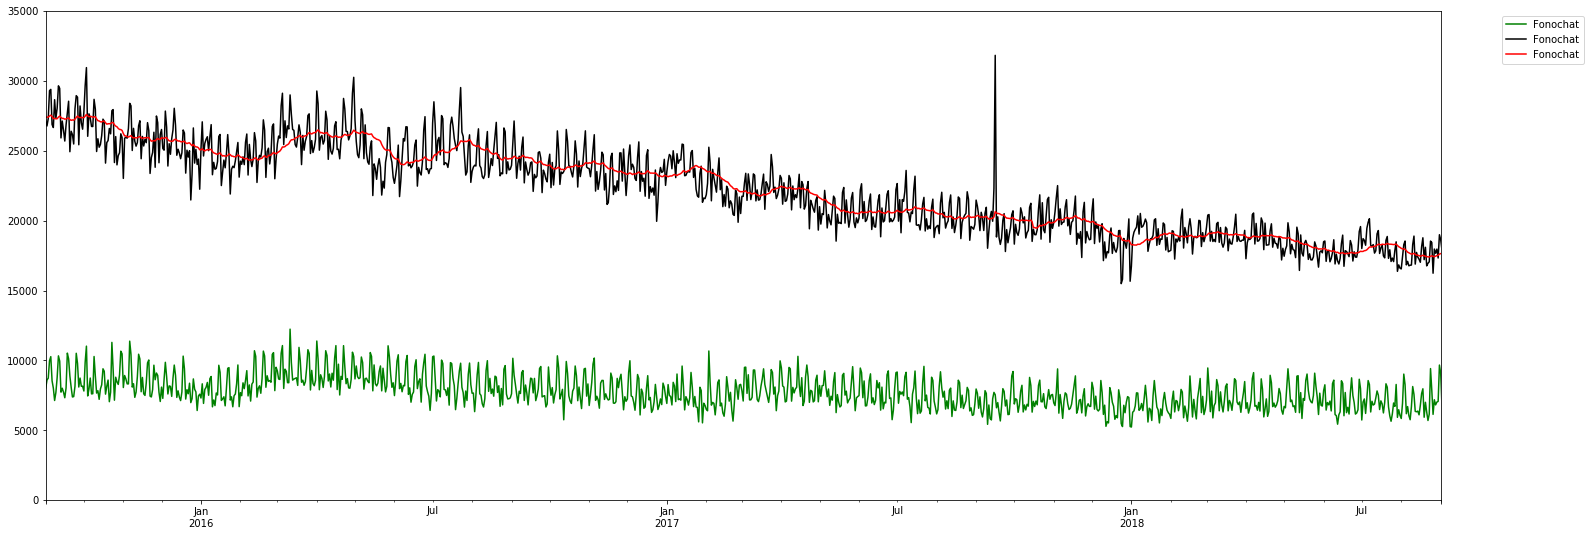

In [54]:
revdaily['Fonochat'].plot(color='green', legend=False, figsize=(25,9))
callsdaily['Fonochat'].plot(color='black')
callsdaily['Fonochat'].rolling(30).mean().plot(color='red')
plt.gca().set_xlim(pd.Timestamp('2015-09'), pd.Timestamp('2018-09'))
plt.gca().set_ylim(0, 35000)

<a name=revtocalls></a>
## Rev-to-Calls ratio

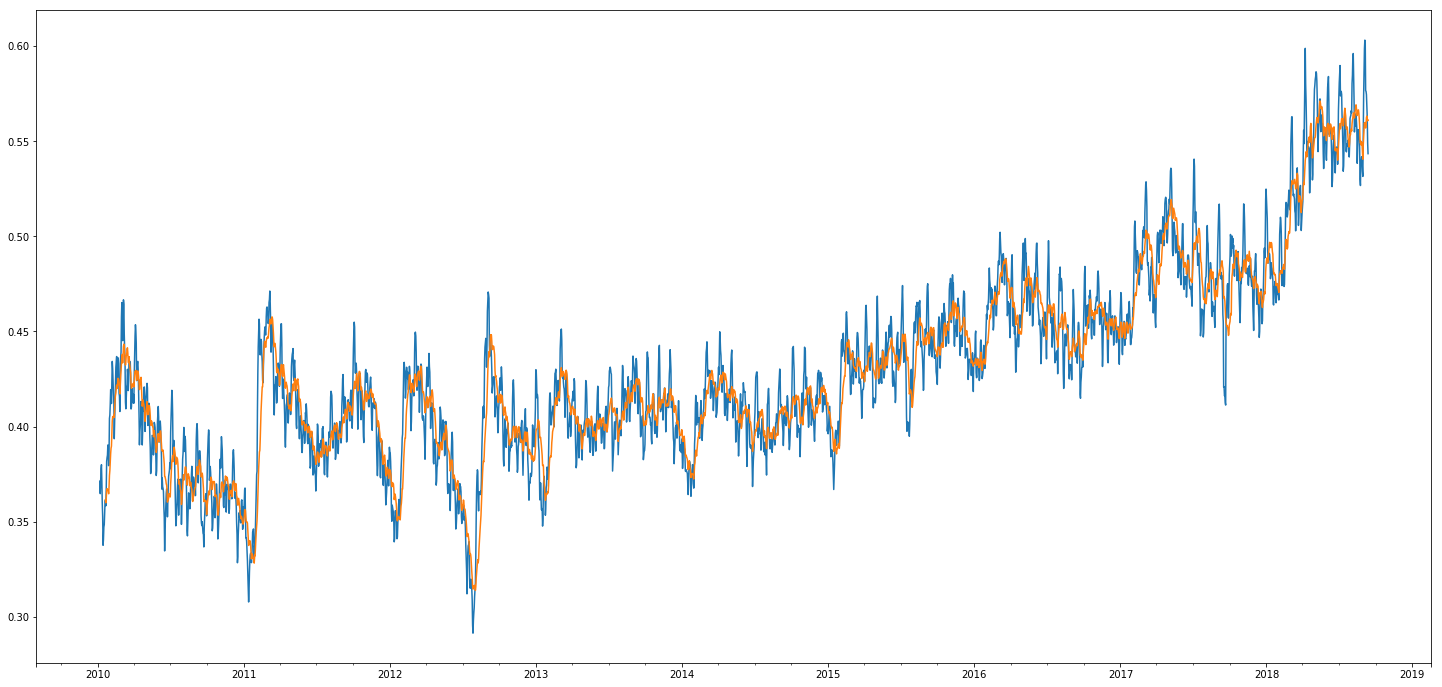

In [214]:
calls_rev_ratio = 1/callsdaily['LiveLinks'].rolling(a).mean().divide(revdaily['LiveLinks'].rolling(b).mean())
calls_rev_ratio2 = 1/callsdaily['LiveLinks'].rolling(c).mean().divide(revdaily['LiveLinks'].rolling(d).mean())
calls_rev_ratio.plot(legend=False, figsize=(25,12))
calls_rev_ratio2.plot()

<a name='explorerevenue_copied'></a>
# Copied over from explorerevenue.ipynb

In [ ]:
df = pd.read_excel('revenue.xls', skiprows=[0,2])
df.fillna(0, inplace=True)

In [ ]:
df.drop(range(103,108),inplace=True)

Rename the date column using df.rename(columns=dict, inplace=True)
Note: this syntax for merging dicts x, y is new to python 3.5:  z = {**x, **y} 

Format the date column as YYYY-MM string, then convert to datetime:

In [7]:
df.rename(columns={**{'Unnamed: 0': 'Date'}, **{df.columns[k]: df.columns[k] for k in range(1, len(df.columns)) }}, inplace=True)

df['Date'] = df['Date'].apply(lambda x: x[2:7] + str(strptime(x[-3::],"%b").tm_mon).zfill(2))

df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

A quick plot of the data:

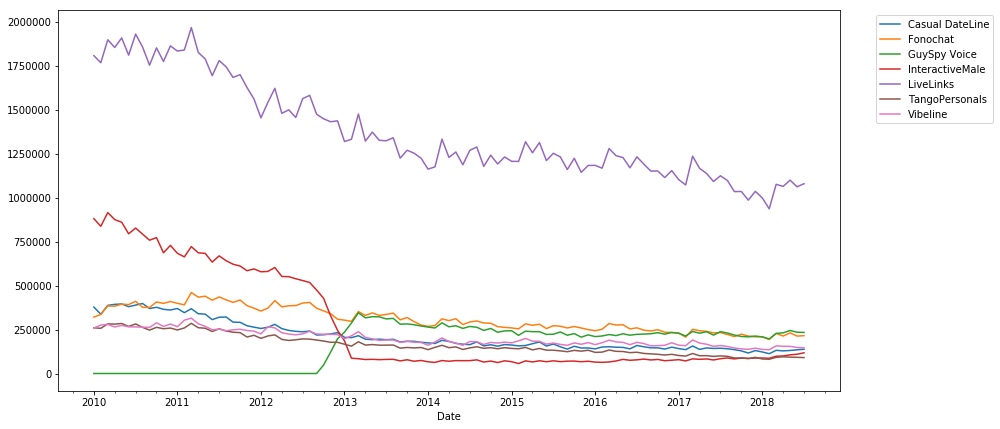

In [11]:
df.plot(legend=False, figsize=(14,7))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [12]:
df['totalrev'] = df.sum(axis='columns')

In [21]:
gross, gross_forecast = fitandforecast(df, 'totalrev')

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


(0, 4000000)

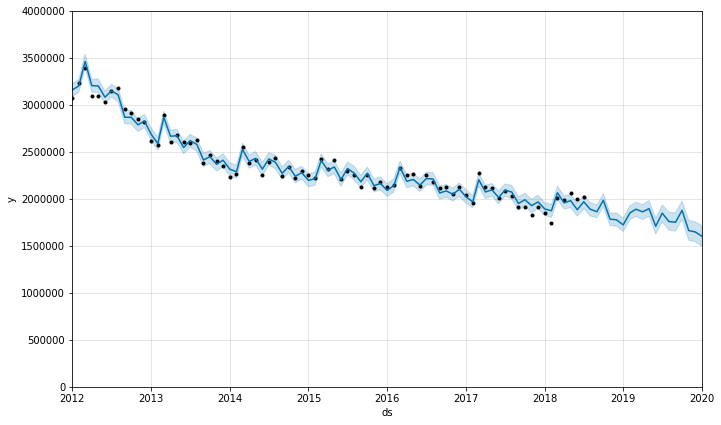

In [22]:
fig_gross = gross.plot(gross_forecast)
gross_ax = plt.gca()
gross_ax.set_xlim(pd.Timestamp('2012'), pd.Timestamp('2020'))
gross_ax.set_ylim([0,4000000])

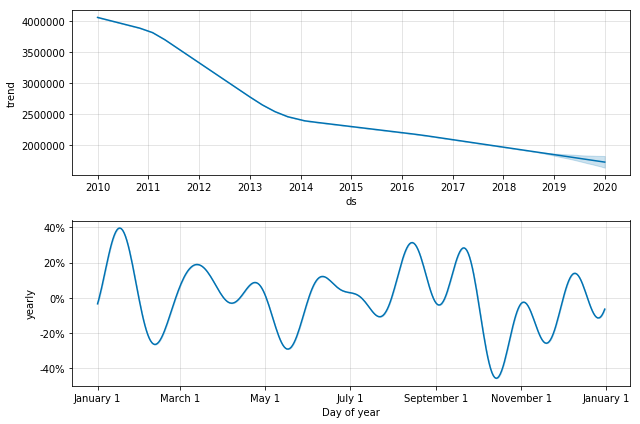

In [23]:
gross_comps=gross.plot_components(gross_forecast)

In [24]:
gross_forecast[gross_forecast['ds'] >= pd.to_datetime('2012-01-01')].head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
24,2012-01-01,3.334436e+06,3.088393e+06,3.227619e+06,3.334436e+06,3.334436e+06,-0.052887,-0.052887,-0.052887,-0.052887,-0.052887,-0.052887,0.0,0.0,0.0,3.158086e+06
25,2012-02-01,3.287681e+06,3.134409e+06,3.268279e+06,3.287681e+06,3.287681e+06,-0.025900,-0.025900,-0.025900,-0.025900,-0.025900,-0.025900,0.0,0.0,0.0,3.202529e+06
26,2012-03-01,3.243943e+06,3.394497e+06,3.541635e+06,3.243943e+06,3.243943e+06,0.067316,0.067316,0.067316,0.067316,0.067316,0.067316,0.0,0.0,0.0,3.462313e+06
27,2012-04-01,3.197205e+06,3.133774e+06,3.273101e+06,3.197205e+06,3.197205e+06,0.002258,0.002258,0.002258,0.002258,0.002258,0.002258,0.0,0.0,0.0,3.204424e+06
28,2012-05-01,3.151974e+06,3.133610e+06,3.275917e+06,3.151974e+06,3.151974e+06,0.015752,0.015752,0.015752,0.015752,0.015752,0.015752,0.0,0.0,0.0,3.201625e+06


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


(0, 500000)

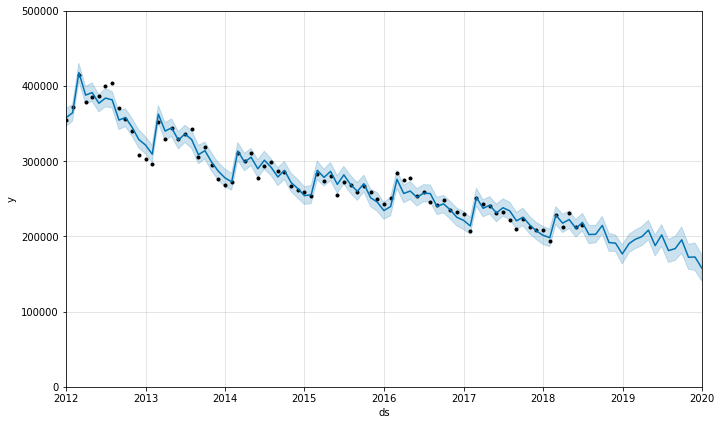

In [25]:
fono, fono_forecast = fitandforecast(df, 'Fonochat')
fig_fono = fono.plot(fono_forecast)
fono_ax = plt.gca()
fono_ax.set_xlim(pd.Timestamp('2012'), pd.Timestamp('2020'))
fono_ax.set_ylim([0,500000])

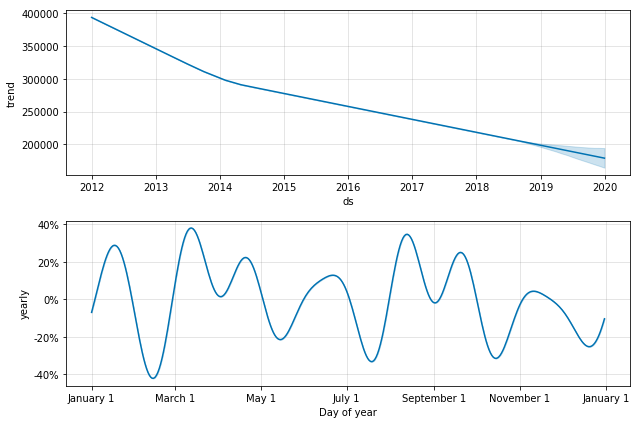

In [26]:
fono_comps = fono.plot_components(fono_forecast[fono_forecast['ds'] >= pd.to_datetime('2012-01-01')])

### Effect of Fourier order on seasonality (totalrev) 